# Assignment 3 Top-Level Code/Notebook
### Training a language model base on Karpathy's minGPT codebase


In [1]:
# The code below is needed for using Google Colab, so un comment this if that is what you're using
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# The code below is also needed for using Google Colab
# BEFORE executing this, you must place the mingpt folder supplied in the assignment
# your google drive, within the folder "Colab Notebooks"
#
# It mounts and changes into the folder that contains mingpt, which you must upload to google drive
# So un-comment it if you've uploaded mingpt to your google drive, into the  "Colab Notebooks" folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [3]:
import torch
import numpy as np

from nltk.tokenize import sent_tokenize

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed
set_seed(1234)

In [4]:
pip install datasets

In [5]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

dataset = load_dataset("glue", "sst2")

train_samples = dataset["train"]["sentence"][:1200]
train_labels = dataset["train"]["label"][:1200]

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_samples, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
class SentimentDataset(Dataset):

    def __init__(self, sentences, labels, truncation=-1):
        """
        :param sentences: List of sentences to be tokenized.
        :param labels: Corresponding labels for each sentence.
        :param truncation: Truncate sentences to a specific length.
        """
        self.sentences = sentences
        self.labels = labels
        self.truncation = truncation

        # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d PyTorch tensors (tokenized sentences)
        for sent in self.sentences:
            tokenized = self.tokenizer(sent).view(-1)  # PyTorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        # Count items and get the max length of tokenized sentences
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.sentences)

    def get_vocab_size(self):
        """
        Return the vocabulary size decided by the BPE tokenizer.
        """
        return 50257  # This should be updated based on the tokenizer used

    def __getitem__(self, idx):
        """
        The output will be a tuple (input_ids, labels), both as PyTorch tensors.
        Input_ids are the tokenized sentence, and labels are the sentiment label.
        """
        x = self.data[idx]
        y = torch.tensor(self.labels[idx], dtype=torch.long)  # Sentiment label (0 or 1)
        return (x, y)

    def get_block_size(self):
        """
        block_size is the maximum sentence length for padding or truncation.
        """
        return 512

In [7]:
train_dataset = SentimentDataset(train_sentences, train_labels)
val_dataset = SentimentDataset(val_sentences, val_labels)

In [8]:
x,y = train_dataset[5]
print(x, y)
print("X: ",train_dataset.tokenizer.decode(x))
print("Y: ",y)

tensor([49123,   616,  1263,  3735,   308, 10316, 10614,   804,   588,   281,
        38264, 10512,   220]) tensor(0)
X:  makes my big fat greek wedding look like an apartheid drama 
Y:  tensor(0)


In [16]:
"""
Full definition of a GPT Language Model, all of it in this single file.

References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math

import torch
import torch.nn as nn
from torch.nn import functional as F

from mingpt.utils import CfgNode as CN

# -----------------------------------------------------------------------------

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class GPT(nn.Module):
    """ GPT Language Model """

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size

        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                # names follow the huggingface naming conventions
                # GPT-1
                'openai-gpt':   dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                # GPT-2 configs
                'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
                'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
                'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
                # Gophers
                'gopher-44m':   dict(n_layer=8, n_head=16, n_embd=512),
                # (there are a number more...)
                # I made these tiny models up
                'gpt-mini':     dict(n_layer=6, n_head=6, n_embd=192),
                'gpt-micro':    dict(n_layer=4, n_head=4, n_embd=128),
                'gpt-nano':     dict(n_layer=3, n_head=3, n_embd=48),
            }[config.model_type])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.classifier_head = nn.Linear(config.n_embd, config.n_classification_class, bias=True)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        """
        Initialize a pretrained GPT model by copying over the weights
        from a huggingface/transformers checkpoint.
        """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel

        # create a from-scratch initialized minGPT model
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 50257 # openai's model vocabulary
        config.block_size = 1024  # openai's model block_size
        model = GPT(config)
        sd = model.state_dict()

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] # ignore these
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla nn.Linear.
        # this means that we have to transpose these weights when we import them
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None, finetune_classify=False):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.classifier_head(x[:, -1, :])

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss


    @torch.no_grad()

    def generate(self, idx, device, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        all_generated_probs = []
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            idx_cond.to(device)
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)

            print(probs)

            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx, torch.cat(all_generated_probs, dim=1)

In [40]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import time
from collections import defaultdict

import torch
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import CfgNode as CN

class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 4
        # optimizer parameters
        C.max_iters = None
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1 # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset, validation_dataset, downstream_finetune=False, collate_fn=None):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.callbacks = defaultdict(list)
        self.collate_fn = collate_fn

        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

        self.downstream_finetune=downstream_finetune

        self.train_losses = []
        self.validation_losses = []

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.validation_losses, label='Validation Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    def compute_accuracy(self, model, dataloader):
        model.eval()  # Switch to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in dataloader:
                batch = [t.to(self.device) for t in batch]
                x_val, y_val = batch
                logits, _ = model(x_val, y_val, self.downstream_finetune)
                predicted = torch.argmax(logits, dim=-1)  # Get the index of the max log-probability
                correct += (predicted == y_val).sum().item()
                total += y_val.size(0)
        return correct / total if total > 0 else 0.0

    def run(self):
        model, config = self.model, self.config

        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)

        # setup the dataloader
        train_loader = DataLoader(
            self.train_dataset,
            sampler=torch.utils.data.RandomSampler(self.train_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=False,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            collate_fn=lambda batch: self.collate_fn(batch, self.device)
        )

        validation_loader = DataLoader(
            self.validation_dataset,
            shuffle=False,
            pin_memory=False,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            collate_fn=lambda batch: self.collate_fn(batch, self.device)
        )

        model.train()
        self.iter_num = 0
        self.iter_time = time.time()
        data_iter = iter(train_loader)
        while True:

            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)
            batch = [t.to(self.device) for t in batch]
            x, y = batch

            # forward the model
            logits, self.loss = model(x, y, self.downstream_finetune)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()

            self.trigger_callbacks('on_batch_end')
            self.iter_num += 1
            tnow = time.time()
            self.iter_dt = tnow - self.iter_time
            self.iter_time = tnow

            if self.iter_num % 100 == 0:
                self.train_losses.append(self.loss.item())
                model.eval()
                validation_loss = 0
                with torch.no_grad():
                    for batch in validation_loader:
                        batch = [t.to(self.device) for t in batch]
                        x_val, y_val = batch
                        _, val_loss = model(x_val, y_val, self.downstream_finetune)
                        validation_loss += val_loss.item()
                validation_loss /= len(validation_loader)
                self.validation_losses.append(validation_loss)
                print(f"Iteration {self.iter_num}, Train Loss:{self.loss.item()}, Validation Loss: {validation_loss}")
                model.train()

            # termination conditions
            if config.max_iters is not None and self.iter_num >= config.max_iters:
                self.plot_losses()
                # Final accuracy on validation set
                final_accuracy = self.compute_accuracy(model, validation_loader)
                print(f"Final Validation Accuracy: {final_accuracy * 100:.2f}%")
                break


In [41]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model_config.n_classification_class = 2
model_config.finetune_classify = True
model = GPT(model_config)

model.load_state_dict(torch.load("model_large100K.pt"))

number of parameters: 2.52M


<ipython-input-41-0d343a9ab4ce>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_large100K.pt"))


<All keys matched successfully>

In [25]:
def classification_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List of input sequences (variable lengths)
    y = [item[1] for item in batch]  # List of labels (0 or 1)
    maxlen = max([len(s) for s in x])

    # Pad input sequences
    padded_x = []
    for sx in x:
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
    padded_x = torch.stack(padded_x).long().to(device)

    y = torch.tensor(y, device=device)

    return padded_x, y

In [44]:
train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 3000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 4    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, collate_fn=classification_collate_fn)


running on device cpu


iter_dt 0.00ms; iter 0: train loss 4.37890
Iteration 100, Train Loss:6.498734474182129, Validation Loss: 4.01597199694758
iter_dt 59.86ms; iter 100: train loss 8.97979
Iteration 200, Train Loss:2.7010629177093506, Validation Loss: 3.3435884941524514
iter_dt 44.66ms; iter 200: train loss 5.27148
Iteration 300, Train Loss:2.8109657764434814, Validation Loss: 2.556063603644725
iter_dt 59.30ms; iter 300: train loss 4.07342
Iteration 400, Train Loss:1.9205001592636108, Validation Loss: 1.8451808718498797
iter_dt 50.04ms; iter 400: train loss 3.71308
Iteration 500, Train Loss:0.24080868065357208, Validation Loss: 1.2656144317239524
iter_dt 41.08ms; iter 500: train loss 1.27970
Iteration 600, Train Loss:1.0279728174209595, Validation Loss: 0.9576411987344424
iter_dt 71.11ms; iter 600: train loss 2.37755
Iteration 700, Train Loss:1.4588202238082886, Validation Loss: 0.8920243307948112
iter_dt 42.99ms; iter 700: train loss 1.04975
Iteration 800, Train Loss:0.4229918122291565, Validation Loss: 0

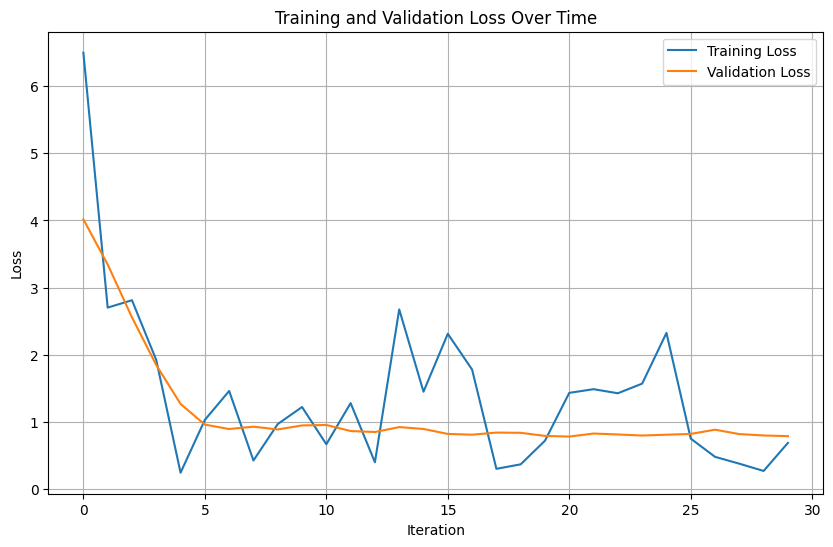

Final Validation Accuracy: 45.00%


In [45]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

# Train!
trainer.run()